In [103]:
!python -m pip install statsmodels

In [104]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot, autocorrelation_plot
from scipy.stats import mstats

In [105]:
filePath = 'Data/sector_51_daily_aqi.csv'
dataFrame = pd.read_csv(filePath)
print(dataFrame.head(5))

   Unnamed: 0        Date    AQI
0           0  2020-03-05   73.0
1           1  2020-03-06   55.0
2           2  2020-03-07   78.0
3           3  2020-03-08  120.0
4           4  2020-03-09  179.0


In [106]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1583 non-null   int64  
 1   Date        1583 non-null   object 
 2   AQI         1581 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.2+ KB


In [107]:
print("Number of missing values in 'AQI':", dataFrame['AQI'].isnull().sum())
dataFrame = dataFrame.dropna(subset=['AQI'])

print("AQI column data types:", dataFrame['AQI'].dtype)

Number of missing values in 'AQI': 2
AQI column data types: float64


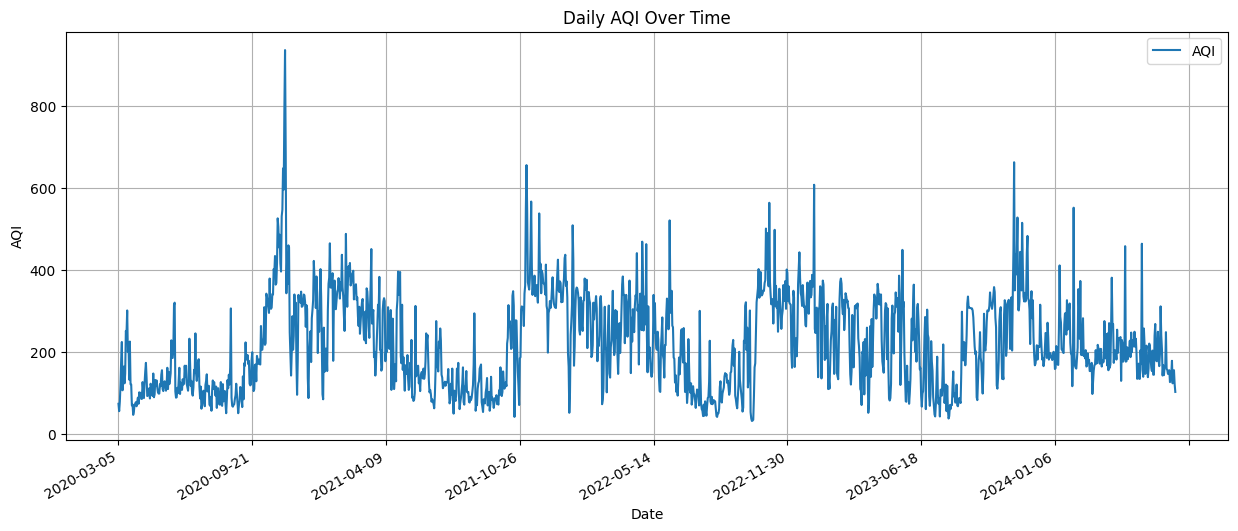

In [108]:
plt.figure(figsize=(15, 6))
plt.plot(dataFrame['Date'],dataFrame['AQI'], label='AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Daily AQI Over Time')
plt.legend()
plt.grid(True)
# Improving date formatting on the x-axis
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) # Show only 10 dates to avoid clutter
plt.gcf().autofmt_xdate() # Rotate date labels

plt.show()

In [109]:
dataFrame['Date_date'] = pd.to_datetime(dataFrame['Date'])
dataFrame['Year'] = dataFrame['Date_date'].dt.year
dataFrame['Month'] = dataFrame['Date_date'].dt.month

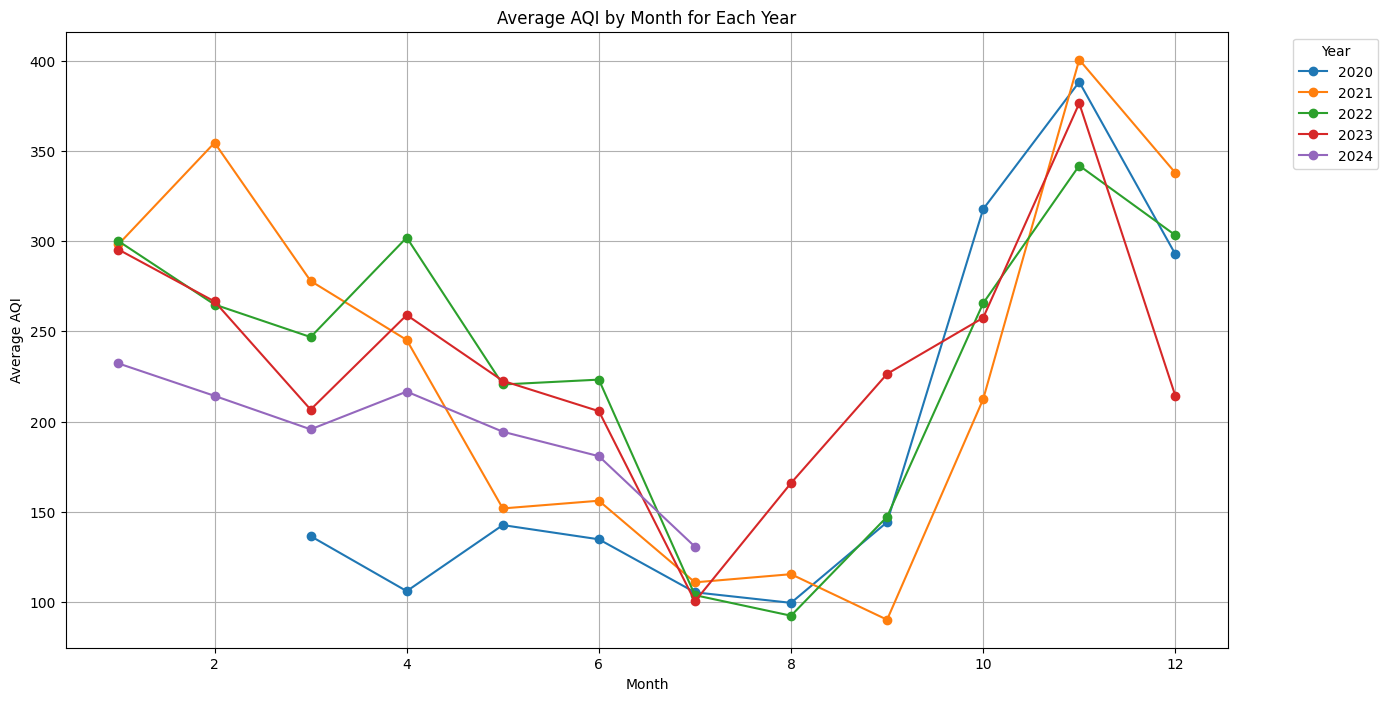

In [110]:
#seasonal each year
monthly_avg = dataFrame.groupby(['Year', 'Month'])['AQI'].mean().unstack()
plt.figure(figsize=(15, 8))
for year in monthly_avg.index:
    plt.plot(monthly_avg.columns, monthly_avg.loc[year], marker='o', label=str(year))
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average AQI by Month for Each Year')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

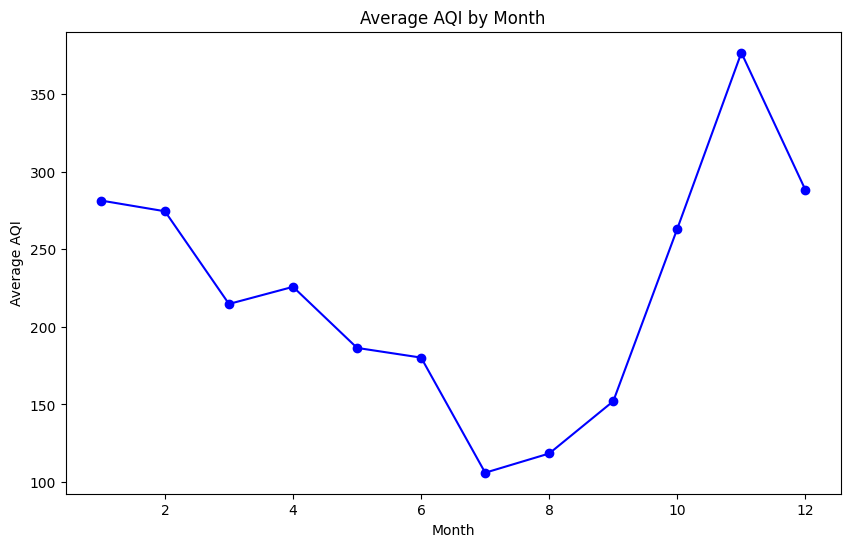

In [111]:
#seasonal Plots
monthly_avg = dataFrame.groupby('Month')['AQI'].mean()
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='line', marker='o', color='b')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average AQI by Month')
plt.show()

### Observing the Lag Plots and ACF plots for better understanding on trend changes

 A LAG plot is a scatter plot that directly shows the relationship between a time series and its lagged versions. On the X-axis, you plot the lagged values (past values), and on the Y-axis, you plot the corresponding original values.

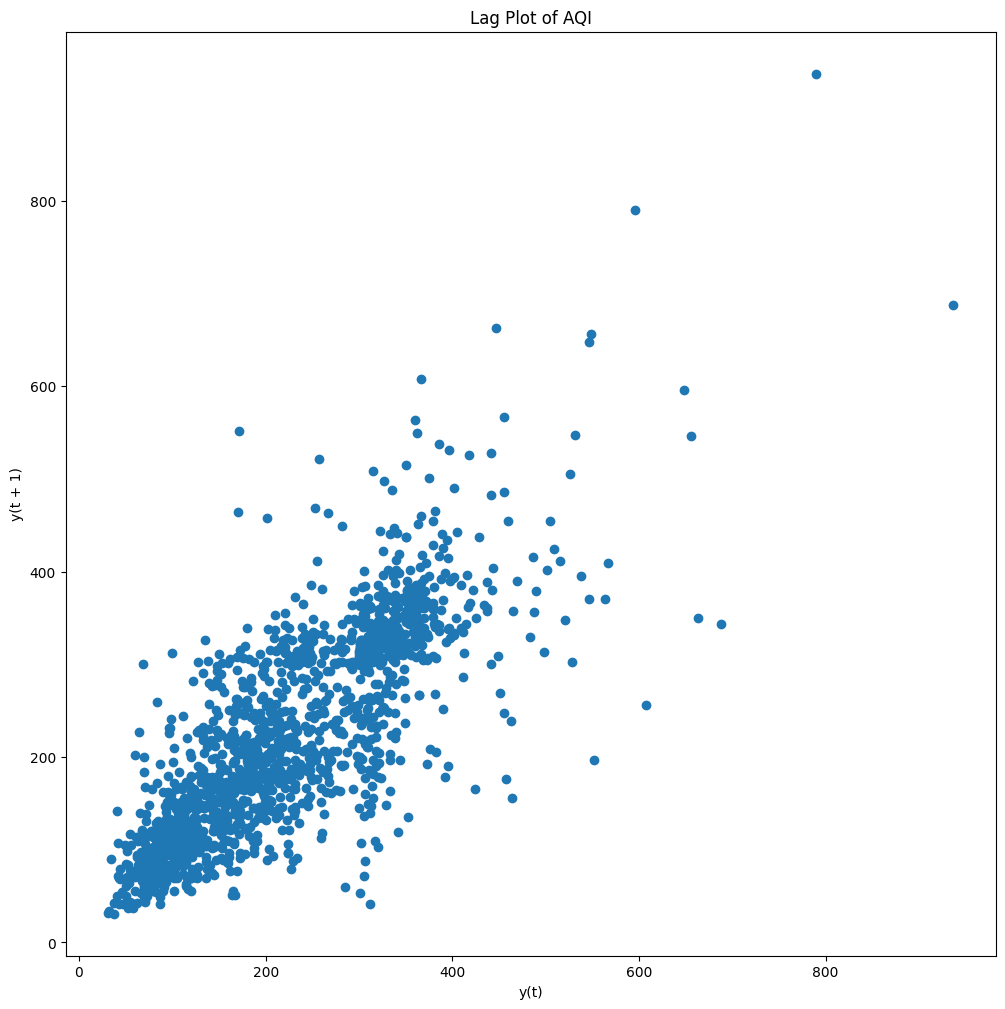

In [112]:
plt.figure(figsize=(12, 12))
lag_plot(dataFrame['AQI'])
plt.title('Lag Plot of AQI')
plt.show()

 The Auto Correlation (ACF) plot measures the correlation between a time series and its lagged versions at different lags. It calculates a correlation coefficient for each lag, which is then plotted against the lag itself.

 Similar to the ACF, the PACF plot measures the correlation between a time series and its lagged versions, but it accounts for the correlations at all previous lags. This helps identify independent relationships between the current value and past values, removing the influence of intermediate lags.

 - ACF measures the overall correlation between the time series and its lagged versions at different lags.
 - PACF measures the partial correlation between the series and its lagged versions at different lags, excluding the influence of all previous lags. It isolates the unique effect of the current lag on the current value.

Ex: The graphs interpretation on the x-value 7 : ACF and PACF both look at how the current value relates to the value 7 days ago, but ACF considers the influence of all previous days (1 to 6), while PACF isolates the unique effect of day 7, excluding those in between. ACF gives a general idea, PACF focuses on independent relationships at specific lags. Use both to get a complete picture

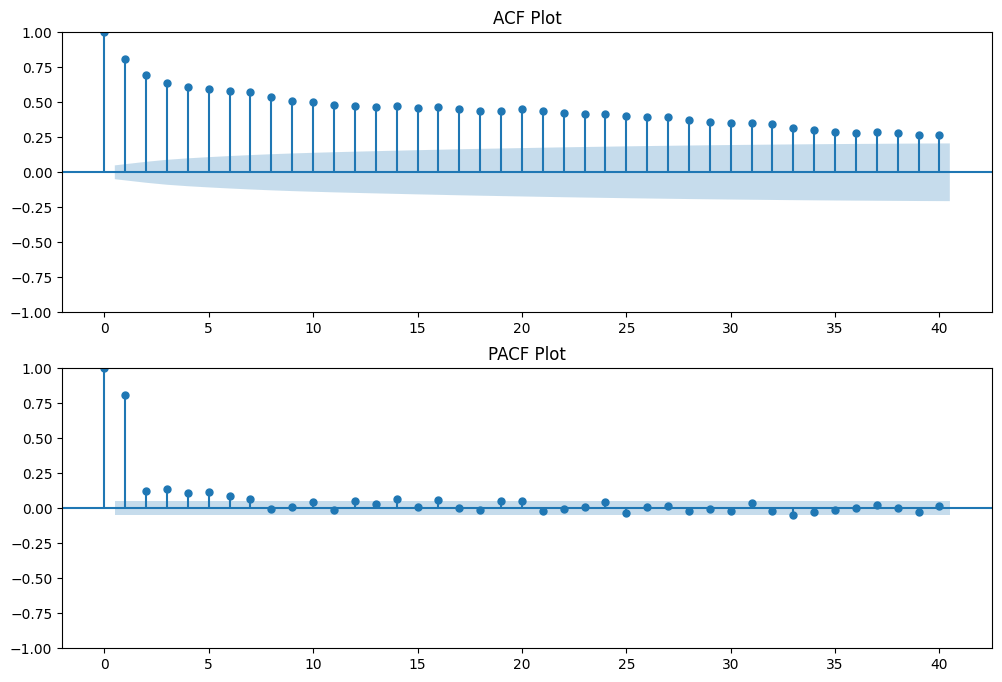

In [113]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(dataFrame['AQI'], lags=40, ax=ax[0])
plot_pacf(dataFrame['AQI'], lags=40, ax=ax[1])
ax[0].set_title('ACF Plot')
ax[1].set_title('PACF Plot')
plt.show()

#### Take Aways from the above graphs
- The ACF values gradually decrease towards zero as the lag increases, it suggests a weakening relationship between past and present values. This might indicate an MA (Moving Average) process or a more complex model might be needed.
- As the PACF value goes to null for the future values it shows that the current value have very less indepenet correlation to the older values

### Looking for the outliners

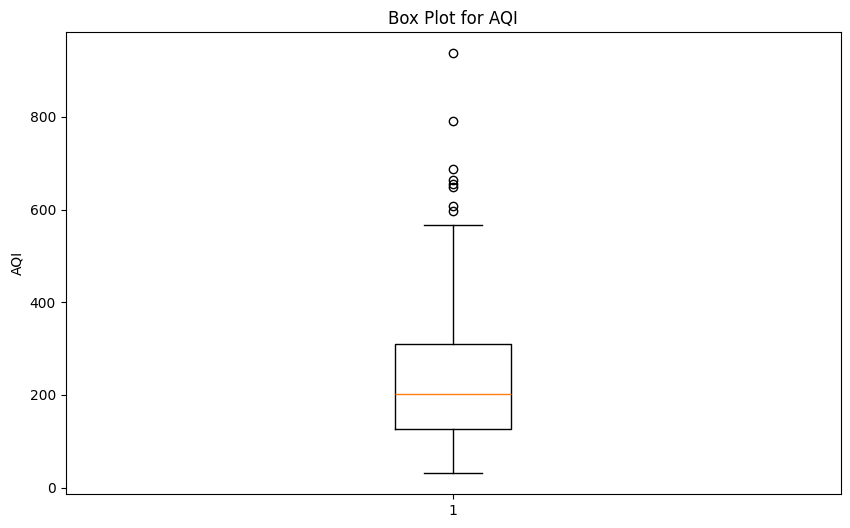

In [114]:
plt.figure(figsize=(10, 6))
plt.boxplot(dataFrame['AQI'])
plt.title('Box Plot for AQI')
plt.ylabel('AQI')
plt.show()


In [115]:
## Using IQR Method
# Calculate Q1 (25th percentile) and Q3 (85th percentile)
Q1 = dataFrame['AQI'].quantile(0.25)
Q3 = dataFrame['AQI'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = dataFrame[(dataFrame['AQI'] < lower_bound) | (dataFrame['AQI'] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])

Number of outliers detected: 8


In [116]:
# Winsorizing Outliers - Mapping the outliners to the nearest non-outlier value
dataFrame.loc[dataFrame['AQI'] < lower_bound, 'AQI'] = lower_bound
dataFrame.loc[dataFrame['AQI'] > upper_bound, 'AQI'] = upper_bound

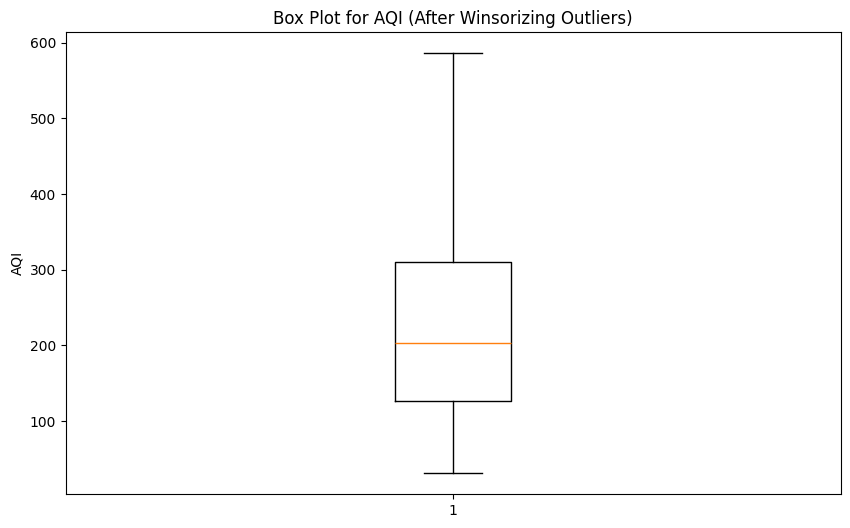

In [117]:
plt.figure(figsize=(10, 6))
plt.boxplot(dataFrame['AQI'].dropna())
plt.title('Box Plot for AQI (After Winsorizing Outliers)')
plt.ylabel('AQI')
plt.show()

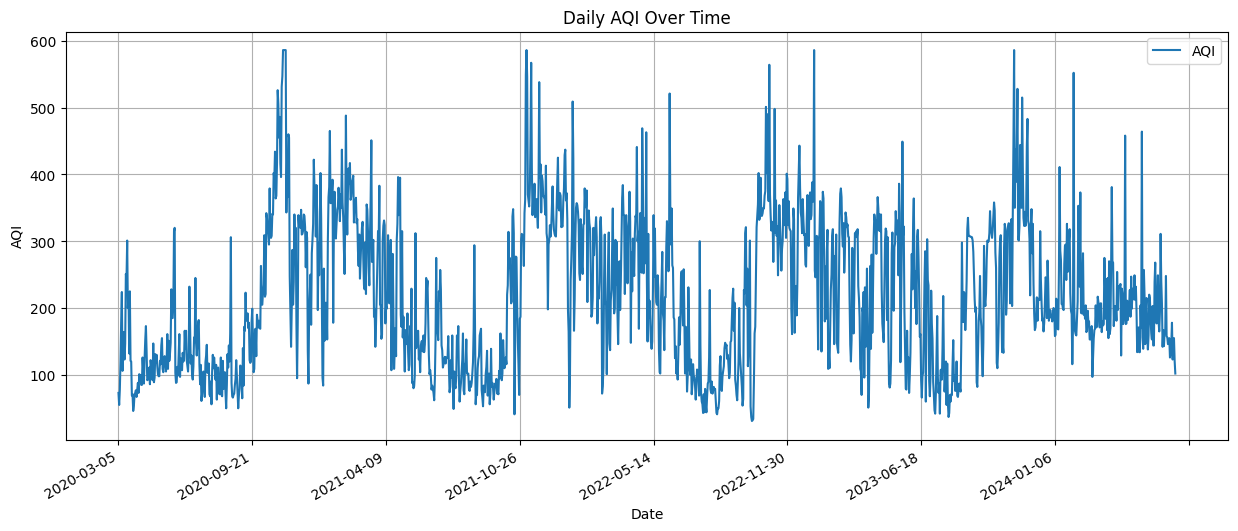

In [118]:
plt.figure(figsize=(15, 6))
plt.plot(dataFrame['Date'],dataFrame['AQI'], label='AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Daily AQI Over Time')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) # Show only 10 dates to avoid clutter
plt.gcf().autofmt_xdate() # Rotate date labels

plt.show()

In [120]:
dataFrame.to_csv('Data/sector_51_daily_aqi_cleaned.csv', index=False)